In [3]:

import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from tensorflow import keras

from functions.image import get_filtered_satellite_float32, get_satellite_raw_uint8, remove_noise_satellite

In [4]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


In [2]:
dataset = rasterio.open("./data/crs.tiff")
img_data = dataset.read(1)
block_size = 30


def get_processed_image(coord):
    return get_filtered_satellite_float32(coord, block_size, img_data, dataset)


def get_raw_image(coord):
    return get_satellite_raw_uint8(coord, block_size, img_data, dataset)

In [3]:
import glob

examples = glob.glob("./examples/*/*.png", recursive=True)

In [4]:
import imageio

X1 = []
Y1 = []
for path in examples:
    category = path.split("/")[2]
    img = imageio.imread(path)
    if category == "boats" or category == "windmills":
        for i in range(4):
            Y1.append(0 if category == "boats" else 1)
            cp = np.expand_dims(remove_noise_satellite(img.copy()) / 255.0, -1)
            X1.append(cp)
            img = np.rot90(img)
    else:
        Y1.append(0)
        img = np.expand_dims(remove_noise_satellite(img) / 255.0, -1)
        X1.append(img)


In [5]:
X2 = []
Y2 = []
for path in examples:
    category = path.split("/")[2]
    img = imageio.imread(path)
    if category == "land" or category == "beach":
        Y1.append(1)
        img = np.expand_dims(img / 255.0, -1)
        X1.append(img)
    else:
        for i in range(4):
            Y1.append(0)
            cp = np.expand_dims(img.copy() / 255.0, -1)
            X1.append(cp)
            img = np.rot90(img)


In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size=0.3)

X_train = np.stack(X_train)
X_test = np.stack(X_test)
Y_train = keras.utils.to_categorical(Y_train, 2)
Y_test = keras.utils.to_categorical(Y_test, 2)

In [7]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

windmill_model = Sequential()

windmill_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
windmill_model.add(MaxPooling2D(pool_size=(2, 2)))
windmill_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
windmill_model.add(MaxPooling2D(pool_size=(2, 2)))
windmill_model.add(Flatten())
windmill_model.add(Dropout(0.5))
windmill_model.add(Dense(2, activation='sigmoid'))

windmill_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2021-12-10 13:50:49.644675: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-10 13:50:49.651567: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rudolf/Projects/cs-ml-windmill/venv/lib/python3.9/site-packages/cv2/../../lib64:
2021-12-10 13:50:49.651584: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-12-10 13:50:49.651937: I tensorflow/core/platform/cpu_

In [16]:
windmill_model.fit(X_train, Y_train, epochs=25)

2021-12-10 13:48:46.615886: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
151/151 [==============================] - 2s 11ms/step - loss: 0.6195 - accuracy: 0.6848

In [152]:
windmill_model.evaluate(X_test, Y_test, verbose=2)


19/19 - 0s - loss: 0.2320 - accuracy: 0.9138


[0.2320317029953003, 0.9137930870056152]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X2, Y2, test_size=0.3)

X_train = np.stack(X_train)
X_test = np.stack(X_test)
Y_train = keras.utils.to_categorical(Y_train, 2)
Y_test = keras.utils.to_categorical(Y_test, 2)

In [ ]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

land_model = Sequential()

land_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
land_model.add(MaxPooling2D(pool_size=(2, 2)))
land_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
land_model.add(MaxPooling2D(pool_size=(2, 2)))
land_model.add(Flatten())
land_model.add(Dropout(0.5))
land_model.add(Dense(2, activation='sigmoid'))

land_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
land_model.fit(X_train, Y_train, epochs=25)

In [ ]:
land_model.evaluate(X_test, Y_test, verbose=2)

found 100 windmills


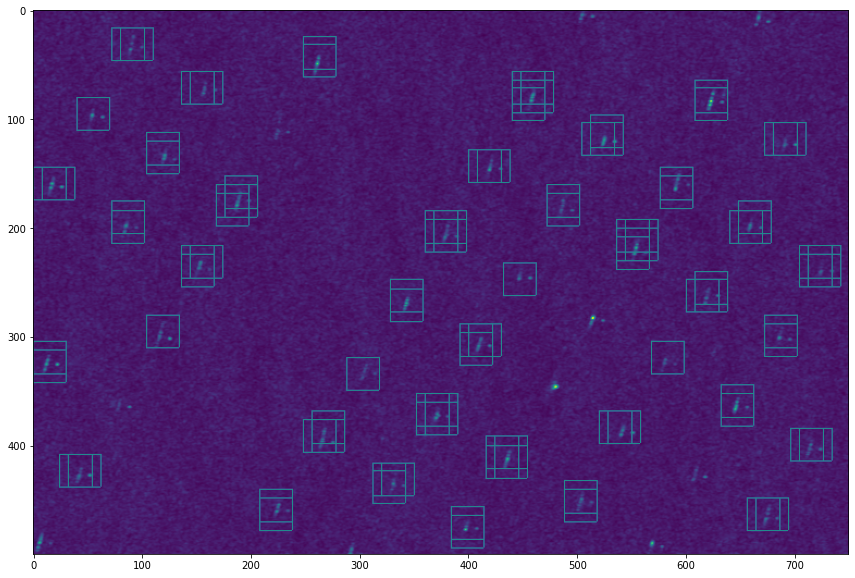

In [158]:
left_top_coord = (1.87709, 51.96248)  # enter coordinate here
img_h, img_w = (750, 500)
left_top_x, left_top_y = dataset.index(left_top_coord[0], left_top_coord[1])
needles = []
step_size = 8

for xx in range(left_top_x + block_size // 2, left_top_x + img_w - block_size // 2, step_size):
    for yy in range(left_top_y + block_size // 2, left_top_y + img_h - block_size // 2, step_size):
        cc = dataset.transform * (yy, xx)
        needles.append({'lon': cc[0], 'lat': cc[1]})

needle_data = np.stack([get_processed_image(coord) for coord in needles])
results = windmill_model.predict(needle_data)

from matplotlib import pyplot as plt

search_space = np.copy(img_data[left_top_x:left_top_x + img_w, left_top_y:left_top_y + img_h])
highlight = np.max(search_space) / 2

found = 0
for i, result in enumerate(results):
    if result[1] > result[0]:
        found += 1
        coord = needles[i]
        xx, yy = dataset.index(coord['lon'], coord['lat'])
        xx -= left_top_x
        yy -= left_top_y

        search_space[xx - block_size // 2:xx + block_size // 2, yy - block_size // 2] = highlight
        search_space[xx - block_size // 2:xx + block_size // 2, yy + block_size // 2] = highlight
        search_space[xx - block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight
        search_space[xx + block_size // 2, yy - block_size // 2:yy + block_size // 2] = highlight

print("found {} windmills".format(found))

plt.rcParams['figure.figsize'] = [20, 10]
plt.imshow(search_space)

In [135]:
from PIL import Image

j = 0

for i, result in enumerate(results):
    if result[1] < result[0]:
        continue
    coord = needles[i]
    a = get_satellite_raw_uint8(coord, block_size, img_data, dataset)
    im = Image.fromarray(a)
    im.save("./examples/%s-%s.png" % (str(coord["lon"]).replace(".", "_"), str(coord["lat"]).replace(".", "_")))
    if j > 200:
        break
    j += 1